In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy 
import datetime

In [2]:
L = 50
u = 0.0001
k1 = 1
k2 = 0.04
eps = 0.01  #TODO eps = 0.01
alpha = 0.0001
F0 = 1
m = 1
h = 0.1
eps2 = 0.05

In [ ]:
#TODO in events u=0,while no events add as much as one event happens ,,,, k1/k2 =  10,20

In [4]:
@njit
def acc(x,v,t):
    xIntoLeft = np.roll(x,-1)
    xIntoRight = np.roll(x,1)
    xIntoLeft[-1] = 0
    xIntoRight[0] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t) )/m

In [5]:
@njit
def acc2(x,v,t):
    return (-x*(2*k1 + k2) + k2*u*t - f2(x,v,t) )/m

In [6]:
@njit
def f(x,v,t):
     xIntoLeft = np.roll(x,-1)
     xIntoRight = np.roll(x,1)
     xIntoLeft[-1] = 0
     xIntoRight[0] = 0
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))
     ### TODO check for v<0

In [7]:
@njit
def f2(x,v,t):
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2)+ k2*u*t) < F0, -x*(2*k1 + k2) + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))
     ### TODO check for v<0

In [8]:
@njit
def tenstion(x,v,t):
    return m*acc(x,v,t) + f(x,v,t)

In [9]:
@njit
def tenstion2(x,v,t):
    return (-x*(2*k1 + k2) + k2*u*t )/m

In [10]:
@njit
def step2(x,v,t):
    k1 = v
    l1 = acc2(x,v,t)

    k2 = v + l1*h/2
    l2 = acc2(x+k1*h/2,v + l1*h/2,t + h/2)

    k3 = v + l2*h/2
    l3 = acc2(x+k2*h/2,v + l2*h/2,t + h/2)

    k4 = v + l3/2
    l4 = acc2(x+k3*h,v + l3*h, t + h)

    xNew = x +  (k1 + 2*k2 + 2*k3 + k4)*h/6
    vNew = v +  (l1 + 2*l2 + 2*l3 + l4)*h/6

    vNew = 0 if vNew < 0 else vNew 
    
    return xNew, vNew,t+h

In [11]:
@njit
def step(x,v,t):
    k1 = v
    l1 = acc(x,v,t)

    k2 = v + l1*h/2
    l2 = acc(x+k1*h/2,v + l1*h/2,t + h/2)

    k3 = v + l2*h/2
    l3 = acc(x+k2*h/2,v + l2*h/2,t + h/2)

    k4 = v + l3/2
    l4 = acc(x+k3*h,v + l3*h, t + h)

    xNew = x +  (k1 + 2*k2 + 2*k3 + k4)*h/6
    vNew = v +  (l1 + 2*l2 + 2*l3 + l4)*h/6

    vNew = np.where(vNew<0, 0, vNew)
    
    return xNew, vNew,t+h

In [12]:
@njit(cache=True)
def np_any_axis1(x):
    """Numba compatible version of np.any(x, axis=1)."""
    out = np.zeros(x.shape[0], dtype=np.bool8)
    for i in range(x.shape[1]):
        out = np.logical_or(out, x[:, i])
    return out

In [12]:
@njit
def run(x,v,t,steps=1_000_000):
    xdata = np.zeros((steps,L),dtype=np.float64)
    vdata = np.zeros((steps,L),dtype=np.float64)
    tenstionData = np.zeros((steps,L),dtype=np.float64)
    for i in range(steps):
        x,v,t = step(x,v,t)
        xdata[i] = x
        vdata[i] = v
        tenstionData[i] = tenstion(x,v,t)

    # slipping = np.any(vdata>0,axis=1)
    slipping = np_any_axis1(vdata>0)

    slippingR = np.roll(slipping,+1)
    slippingL = np.roll(slipping,-1)

    slippingR[0] = False
    slippingL[-1] = False 

    ends  = np.logical_xor( slipping ,(slipping *slippingL))
    starts  = np.logical_xor( slipping ,(slipping *slippingR))

    totalX = np.sum(xdata,axis = 1)

    eventsSize = totalX[np.argwhere(ends)[:,0]] - totalX[np.argwhere(starts)[:,0]]
    eventsBlocks = np.sum(xdata[ends]!=xdata[starts],axis=1).reshape(-1,1)


    #print(np.argwhere(ends)-np.argwhere(starts))

    # time = str(datetime.datetime.now())
    # np.save("xdata-"+time,xdata)
    # np.save("vdata-"+time,vdata)

    ls = np.sum(tenstionData[np.argwhere(starts)[:,0]] >= (1-eps2),axis=1)

    


    return x,v,t,eventsSize,eventsBlocks,ls


In [13]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float64) 
v = np.zeros(L,dtype=np.float64)
t = 0

In [14]:
dataDic = {}
for i in range(1,L+1):
    dataDic[i] = []


In [15]:
run(x,v,t,1_000_000)

/tmp/ipykernel_26968/3926994627.py:7: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  x,v,t = step(x,v,t)


(array([14.84890518, 27.06630375, 37.12135044, 45.4042065 , 52.23077379,
        57.86591906, 62.51738159, 66.35407804, 69.51144691, 72.10080407,
        74.21587297, 75.9385955 , 77.34648851, 78.5027709 , 79.45530029,
        80.21663775, 80.81904063, 81.30690395, 81.70449315, 82.02447028,
        82.28596964, 82.49274726, 82.61554307, 82.63965462, 82.59039204,
        82.47127508, 82.31059271, 82.12320558, 81.9322136 , 81.96012888,
        81.97294961, 81.98433659, 81.89836611, 81.67820714, 81.32362722,
        80.87518896, 80.36463898, 79.63540373, 78.52776537, 77.02300048,
        75.11246277, 72.75904161, 70.02492809, 66.75492032, 62.69039732,
        57.51069497, 50.73838493, 42.18783192, 31.11568386, 17.03798952]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 100000.00000133288,
 array([9.28706678e-0

In [125]:
x,v,t,eventsSize,eventsBlocks,ls= run(x,v,t,1_000_000)

In [38]:
for j in range(1000):
    x,v,t,eventsSize,eventsBlocks,ls= run(x,v,t,1_000_000)



    time = str(datetime.datetime.now())
    
    np.save("eventsSize-"+time,eventsSize)
    np.save("eventsBlocks-"+time,eventsBlocks)
    np.save("ls-"+time,ls)

    for i in range(eventsSize.shape[0]):
        dataDic[int(ls[i])].append(float(eventsSize[i]))

    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
for i in list(dataDic.values()):
    num += len(i)

print(num)

53874


In [45]:
import whisper

In [46]:
model = whisper.load_model("base")

100%|████████████████████████████████████████| 139M/139M [12:44<00:00, 190kiB/s]


In [47]:
result = model.transcribe("4_5805242599463718980.mp4")

In [48]:
print(result["text"])

 Hi there and welcome to Parenting. Let's all be good parents, somehow. Now Parenting is a very powerful method in After Effects that will allow you to almost replicate animations from one layer to another. And it's like a follow along if you like. But also it will allow you to do very powerful animations very easily and that's important. Let's dive in Parenting and start doing something awesome. First of all, let's open a project, file and open project. In your assets inside Parenting, you have the artwork, space ships, and then you can go to the After Effects project. You can open the start to follow along with me. I will open the final. You can have the final animations that you are going to do. First of all, you notice something strange here. There is a star here, somehow and has a lot of black. And also this guy here, the hologram has some black. It seems there is something wrong. Actually what's wrong is that in Illustrator, they applied a certain mode. And this mode is not impor

In [30]:
dataDic

{0: [],
 1: [0.45779123410829925,
  0.45779129056609236,
  0.4511880486388691,
  0.4577924676123075,
  0.45779222195778857,
  1.4002540344445151,
  0.4511872126458911,
  0.9240379863986163,
  0.4577916611051478,
  0.4511880259778991,
  0.45118735905271024,
  1.0418573867209489,
  0.899562841084844,
  22.353648955802782,
  0.45118741865007905,
  0.45118678905419074,
  0.457790883621783,
  0.4577908864666824,
  0.45118735285359435,
  0.45118703016487416,
  0.9230742441141047,
  0.45118813985027373,
  1.4311419492587447,
  0.9350787193980068,
  0.45779164394480176,
  0.4511875786265591,
  1.4647345335251885,
  1.7505145340401214,
  0.457792202141718,
  1.8676227409305284,
  0.4511878448392963,
  1.4716313701937906,
  0.4511873215378728,
  0.45118740655016154,
  5.519937693054089,
  0.4511877593904501,
  0.45118738809833303,
  0.9110612369986484,
  0.45779192220652476,
  4.958517095801653,
  0.45779101026710123,
  0.4511879165947903,
  1.042392242292408,
  0.4577919454604853,
  1.053701569

In [36]:
import json 

In [40]:

with open("dataDics2.json", "w") as outfile: 
    json.dump(dataDic, outfile)

In [41]:
means = np.zeros(L)
vars = np.zeros(L)
for i in range(1,L):
    means[i] = np.mean(dataDic[i])
    vars[i]=  np.var(dataDic[i])
    


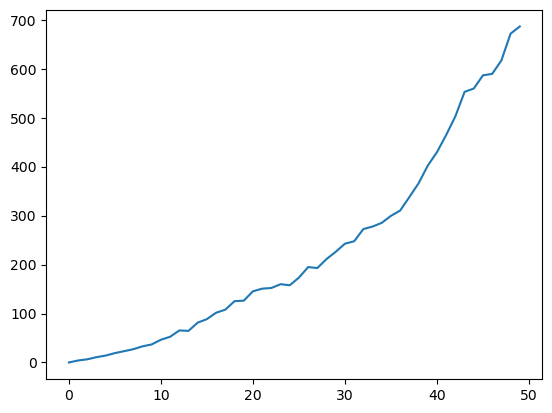

In [42]:
plt.plot(np.arange(L),means)

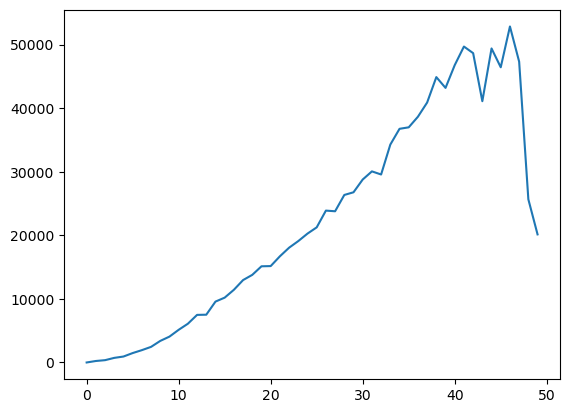

In [43]:
plt.plot(np.arange(L),vars)

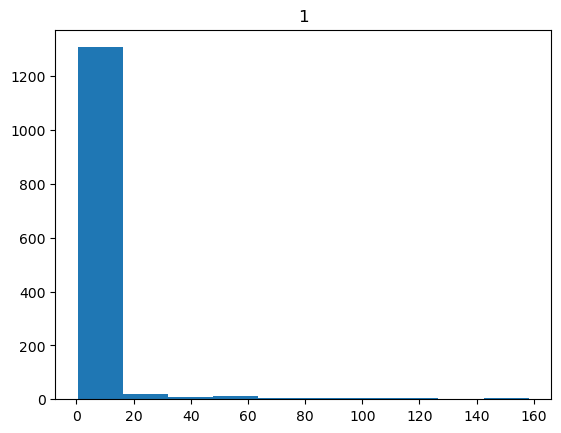

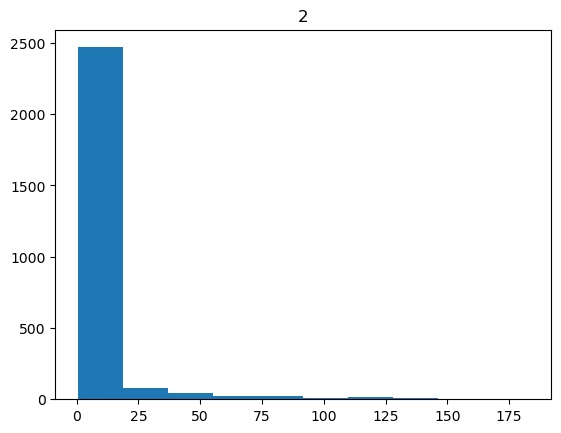

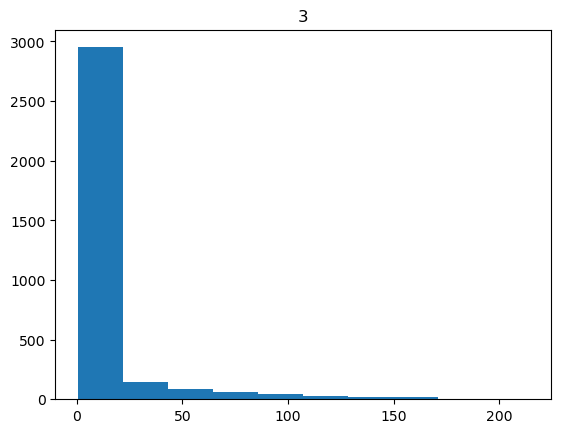

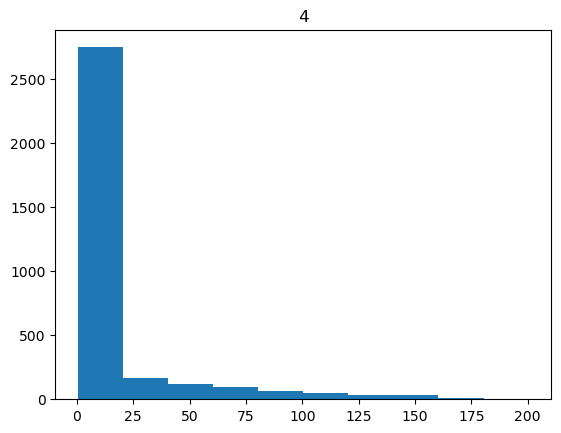

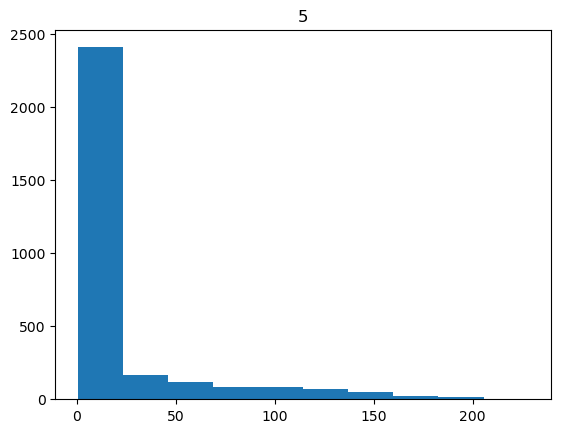

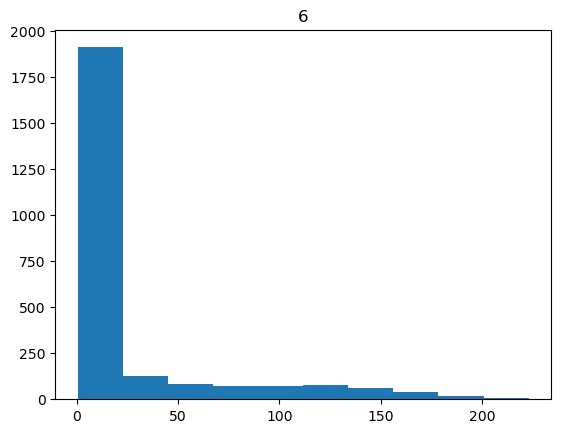

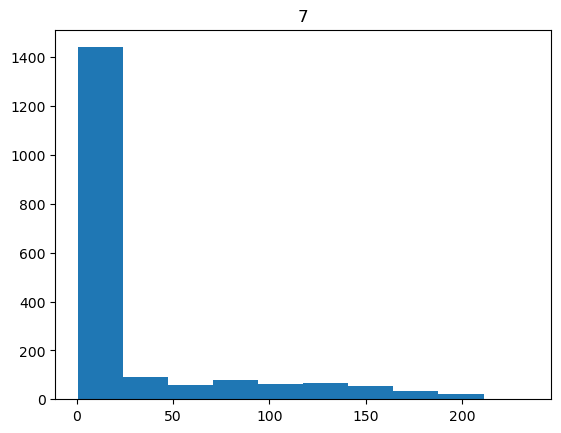

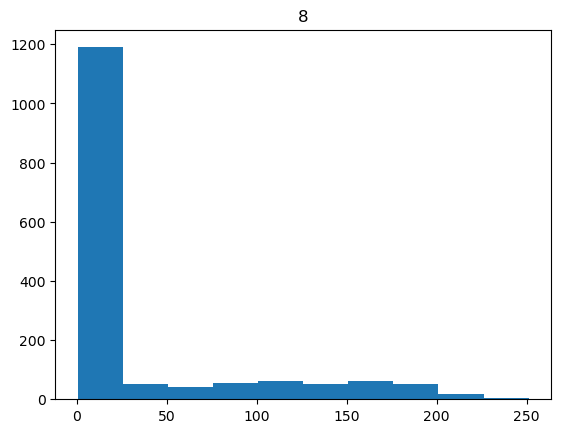

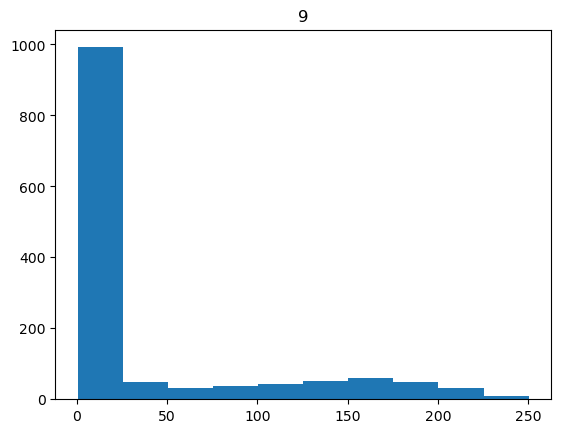

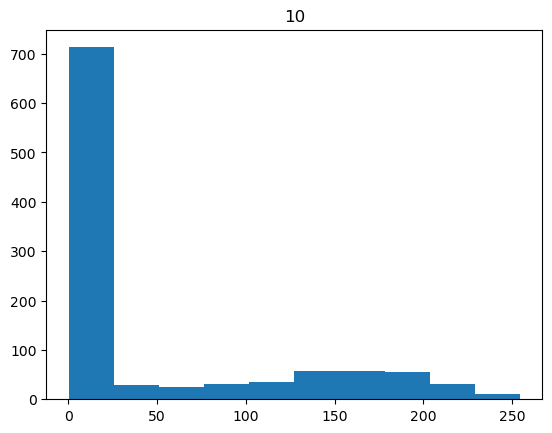

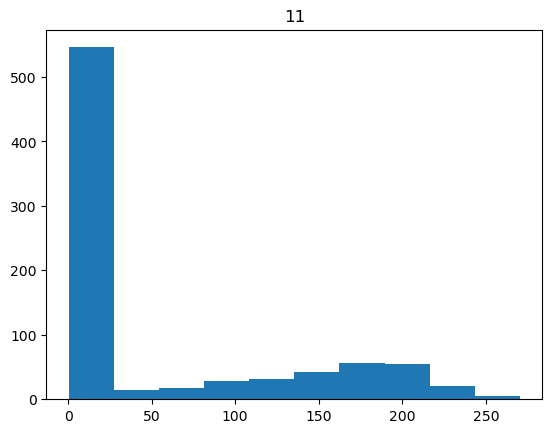

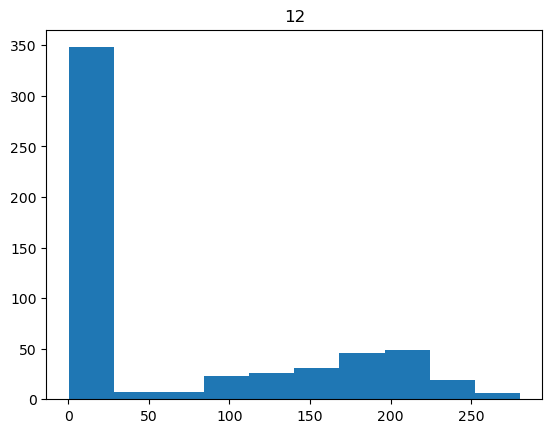

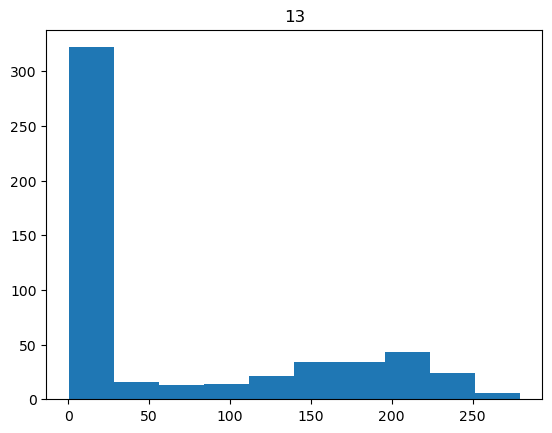

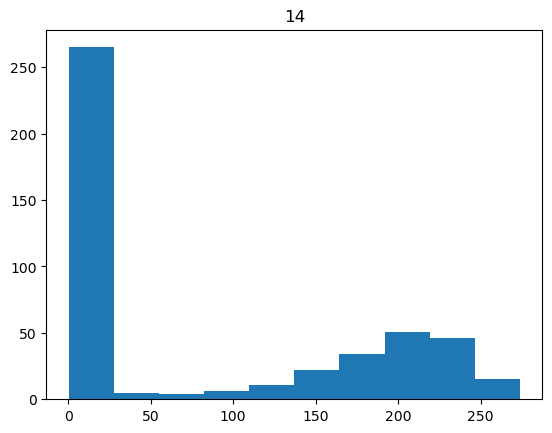

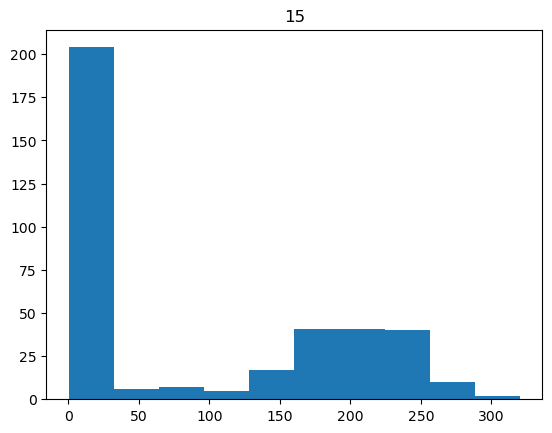

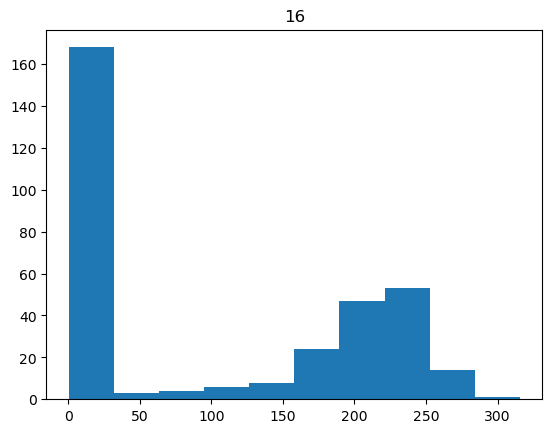

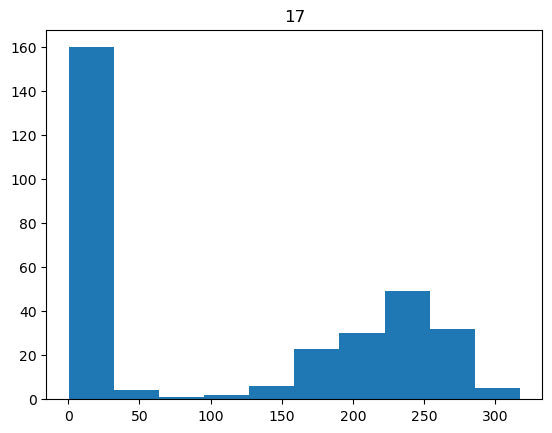

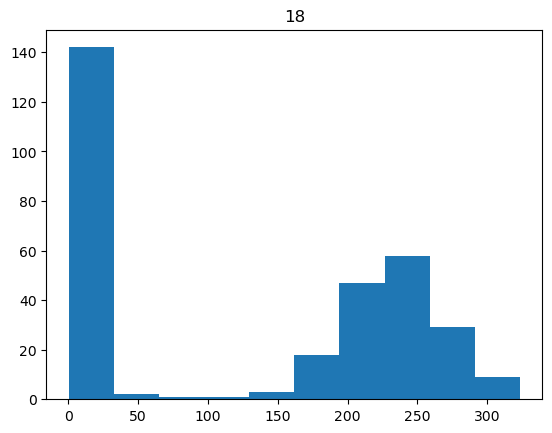

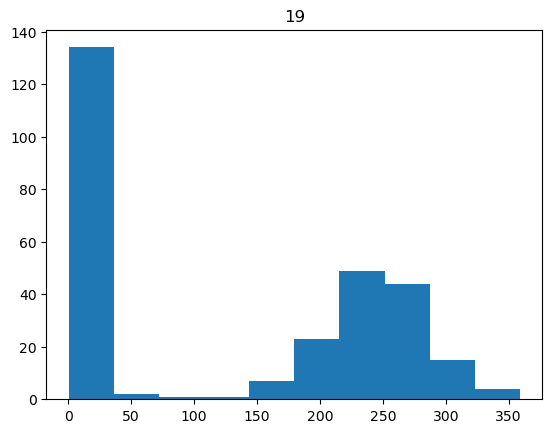

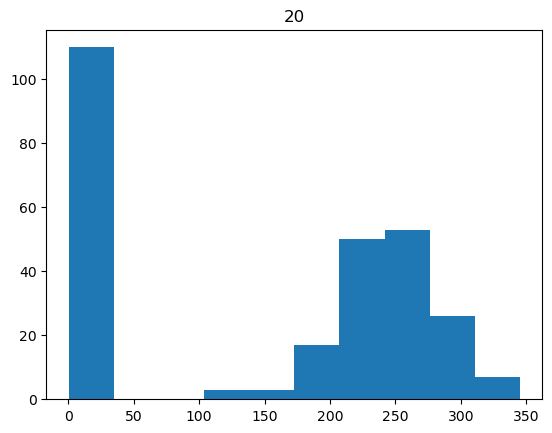

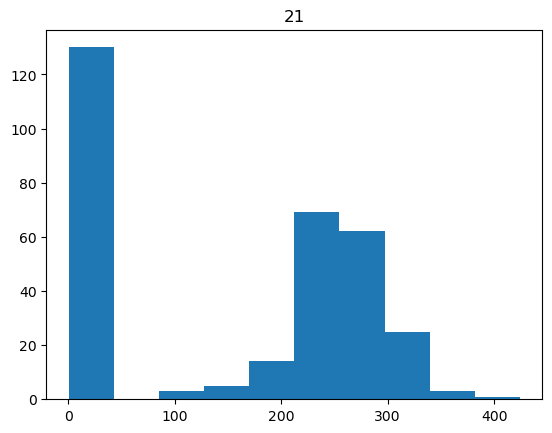

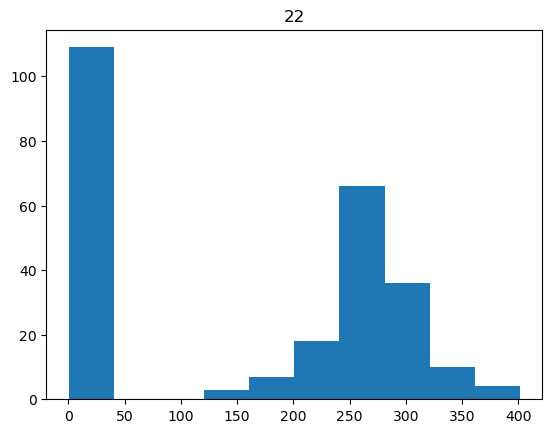

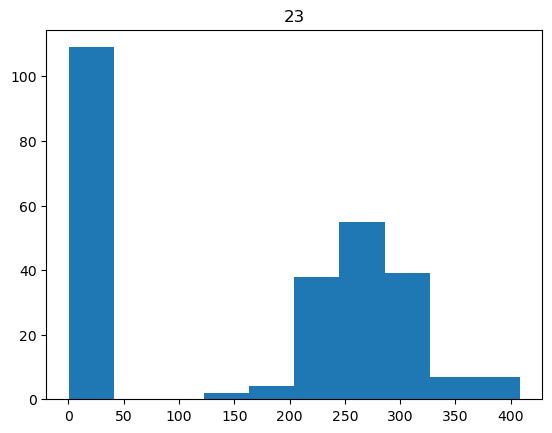

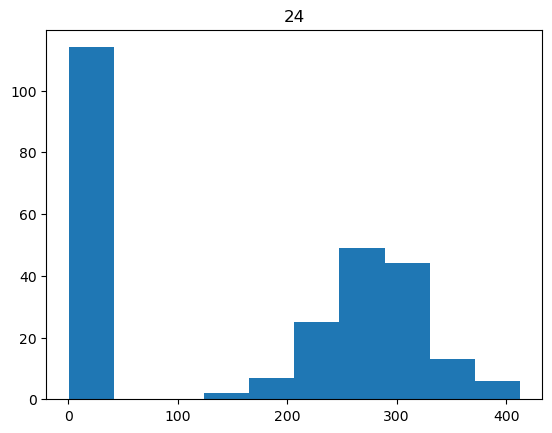

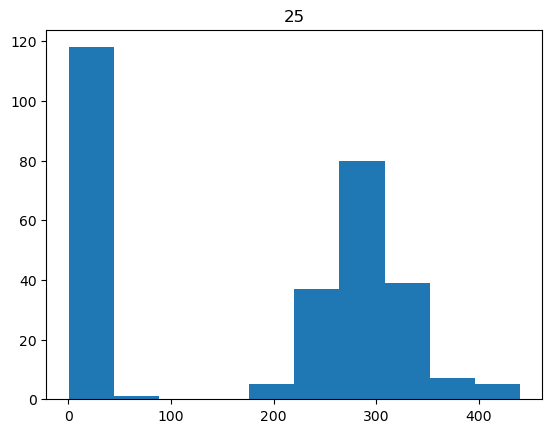

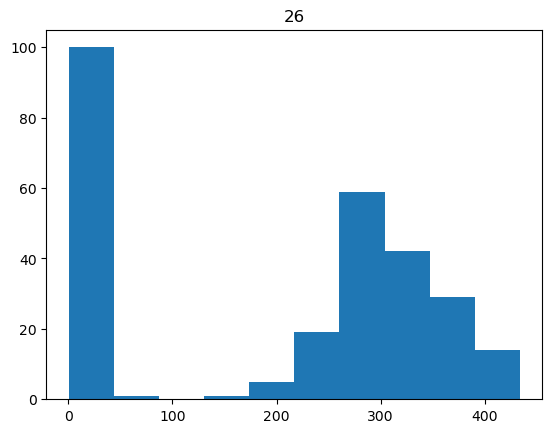

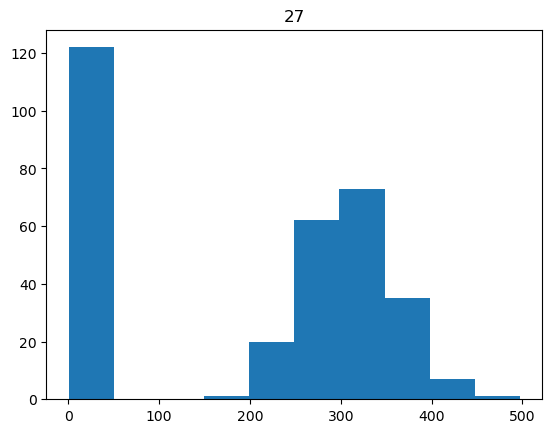

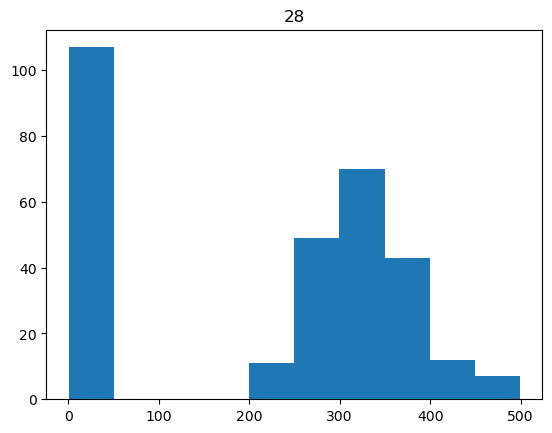

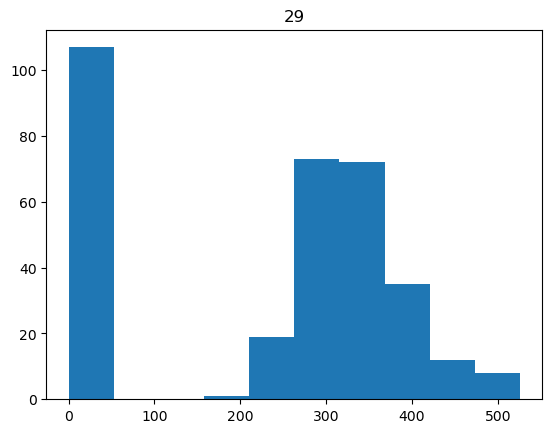

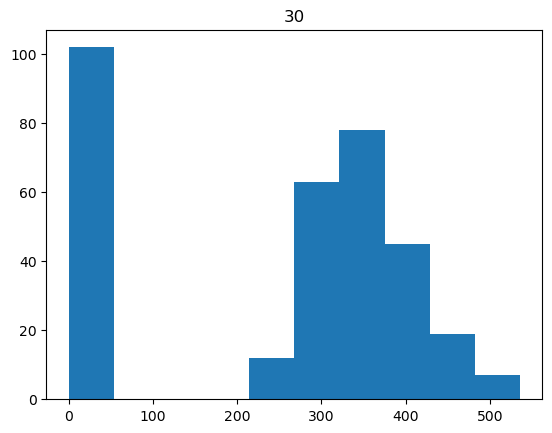

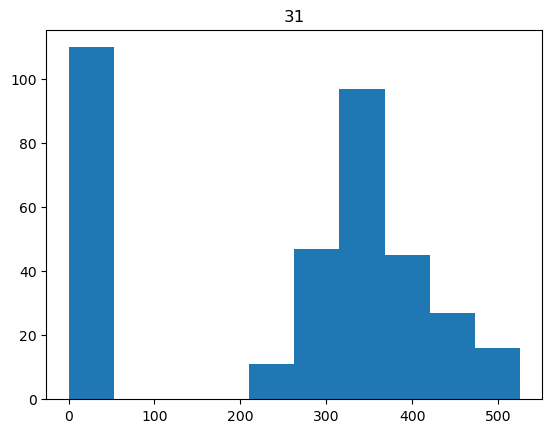

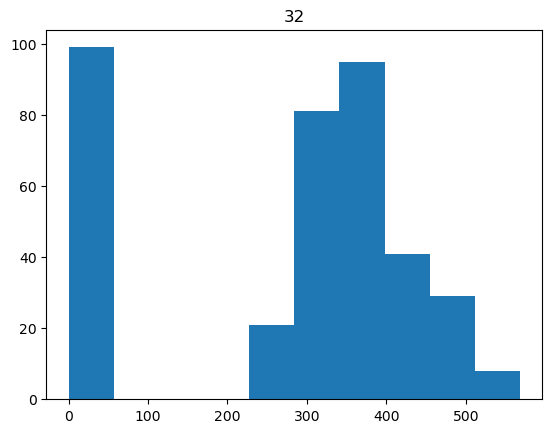

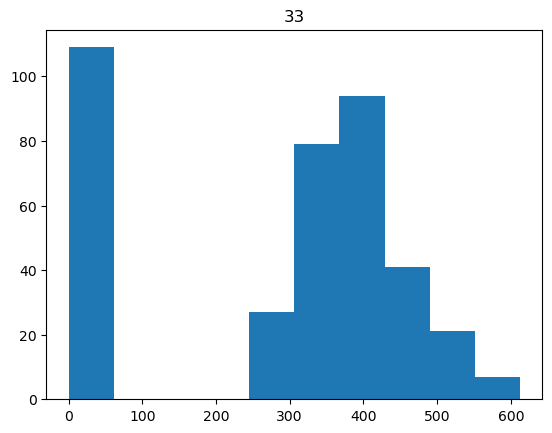

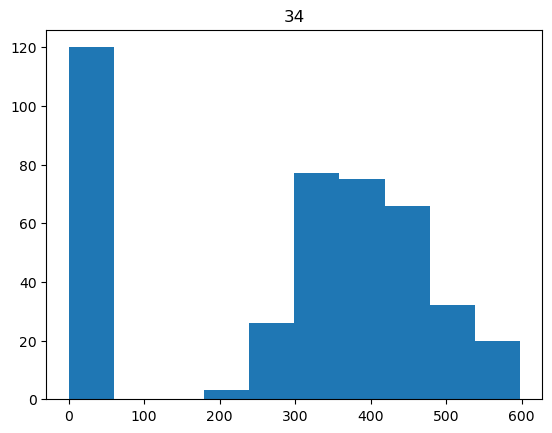

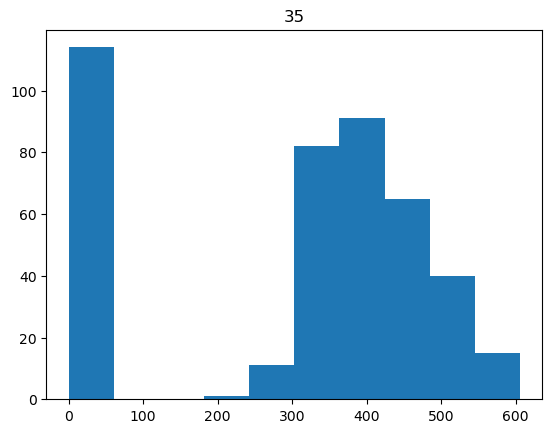

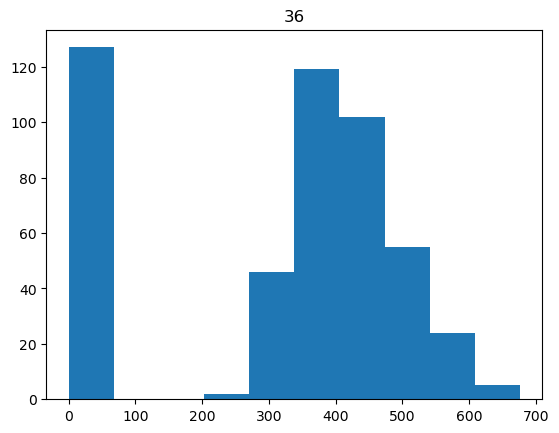

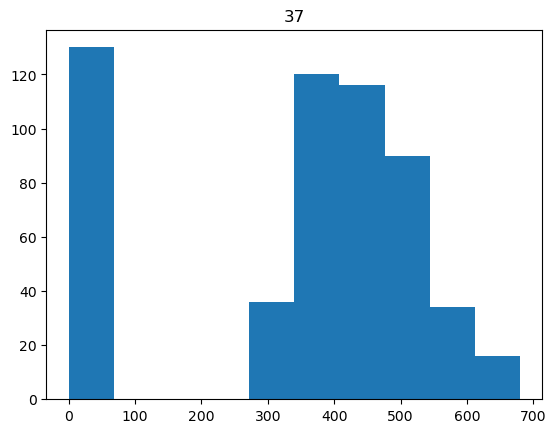

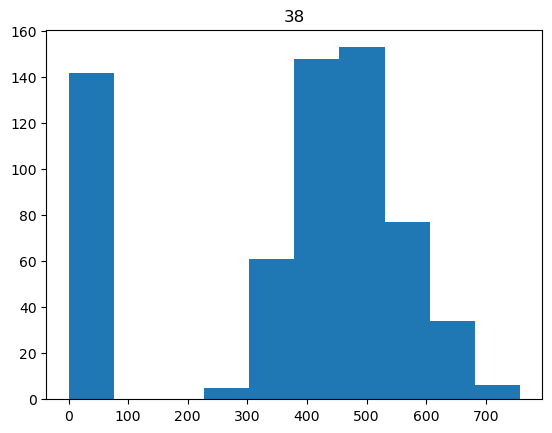

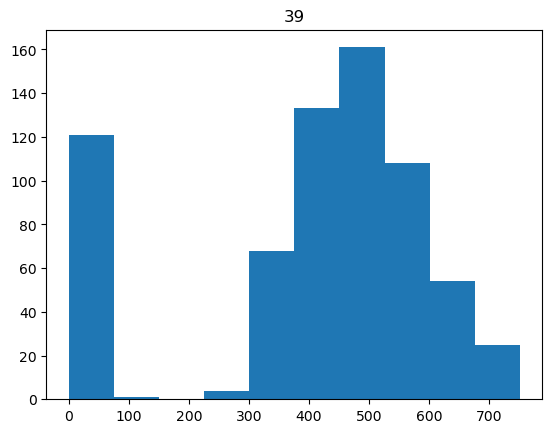

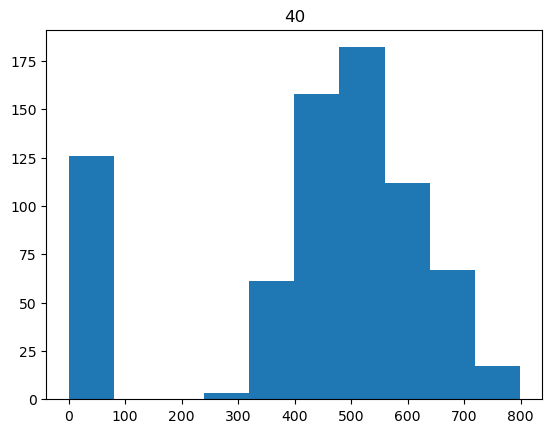

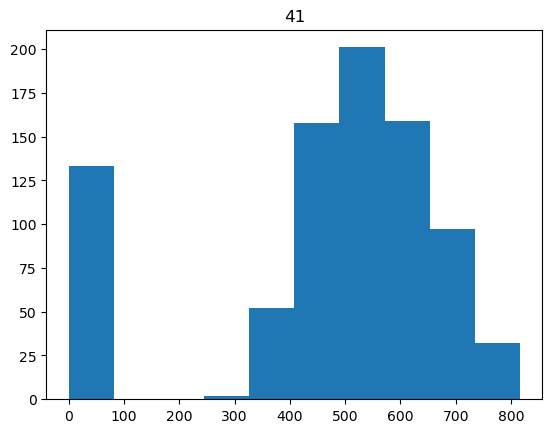

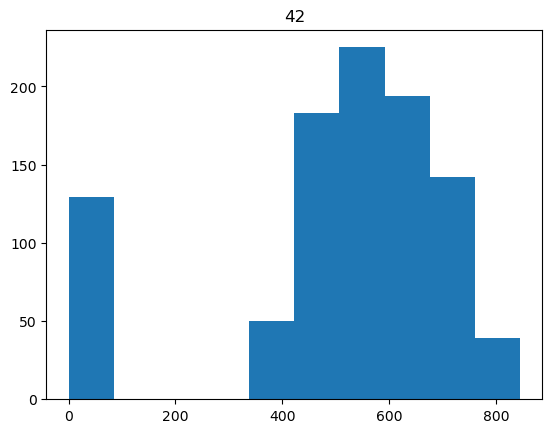

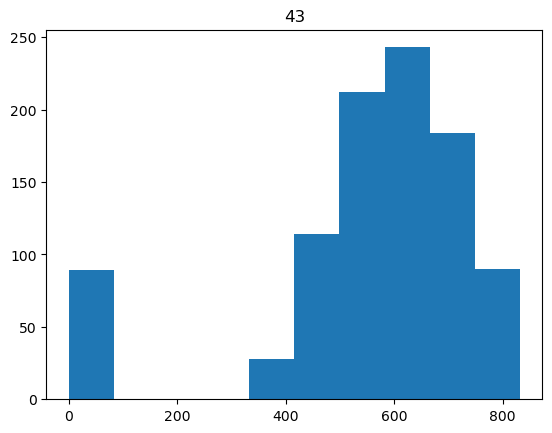

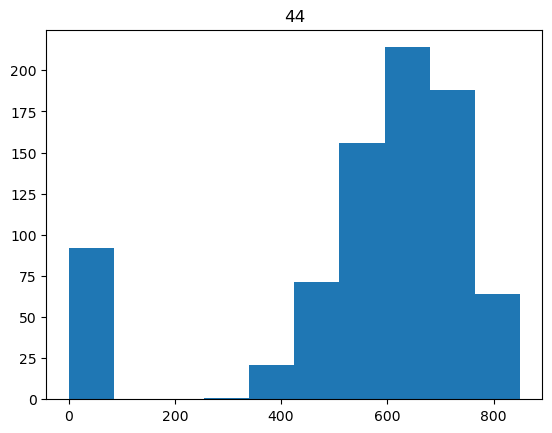

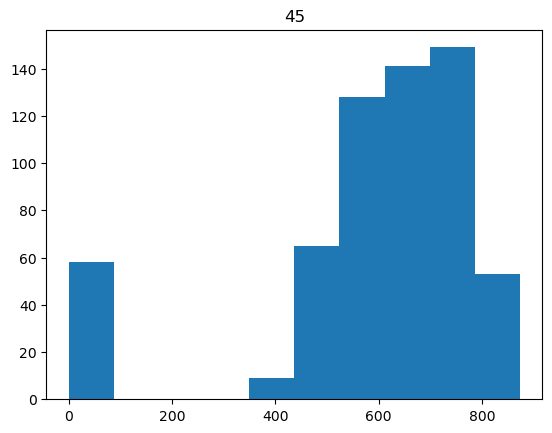

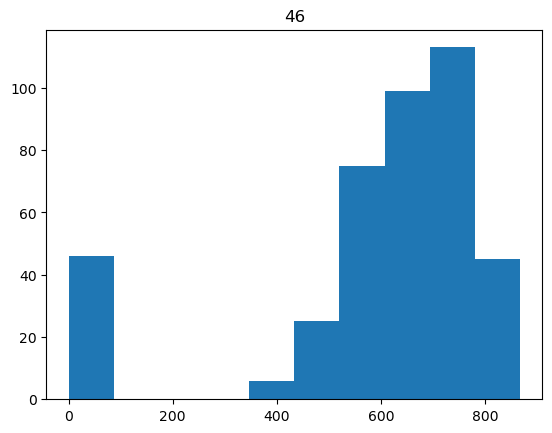

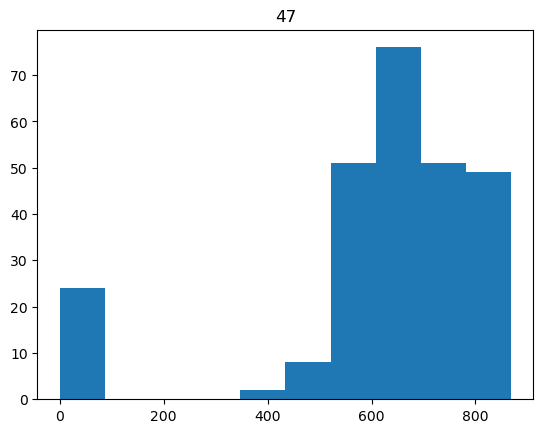

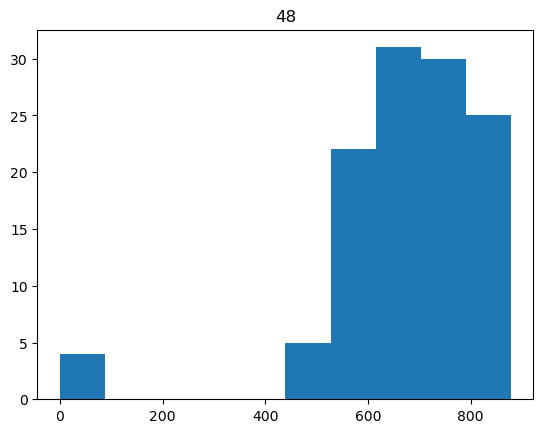

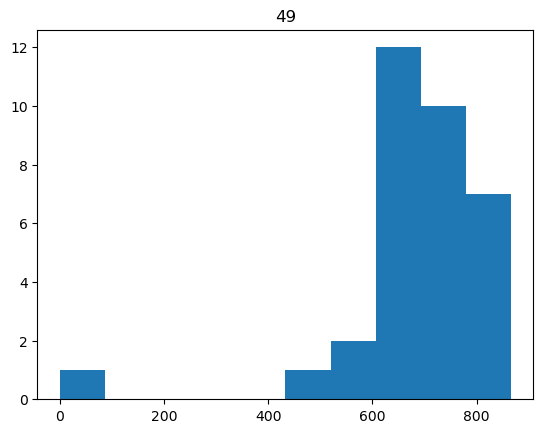

In [44]:
for i in range(1,L):
    plt.title(i)
    plt.hist(dataDic[i])
    plt.show()

In [124]:
# for eps2 in np.arange(0.32,0.34,0.001):
#     x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float32) 
#     v = np.zeros(L,dtype=np.float32)
#     t = 0

#     x,v,t,eventsSize,eventsBlocks,ls= run(x,v,t,10_000_000)

#     par = np.linalg.norm(ls[:,0]- eventsBlocks[:,0])
#     print(eps2, par)

0.32 318.3834166535688
0.321 311.3647378878989
0.322 261.9236529983499
0.323 274.7544358149655
0.324 288.5359596306845
0.325 299.2072860075436
0.326 279.4995527724508
0.327 320.99532706879086
0.328 280.53520278211073
0.329 301.18266882408756
0.33 259.5399776527693
0.331 277.36618395182927
0.332 279.62296043064845
0.333 277.05956038368356
0.334 276.31503759296197
0.335 283.4572278140037
0.336 295.1796063416306


KeyboardInterrupt: 

<BarContainer object of 15 artists>

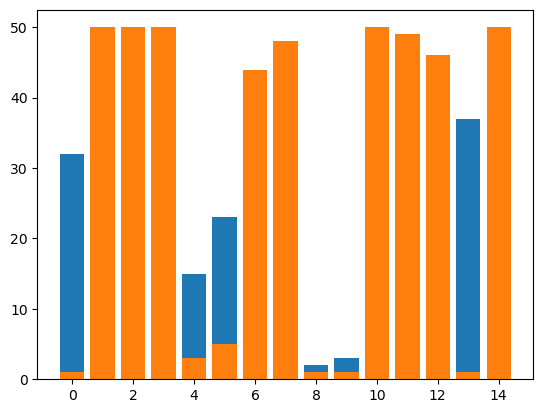

In [142]:
plt.bar(np.arange(eventsSize.shape[0]),ls[:,0])
plt.bar(np.arange(eventsSize.shape[0]),eventsBlocks[:,0])

<BarContainer object of 15 artists>

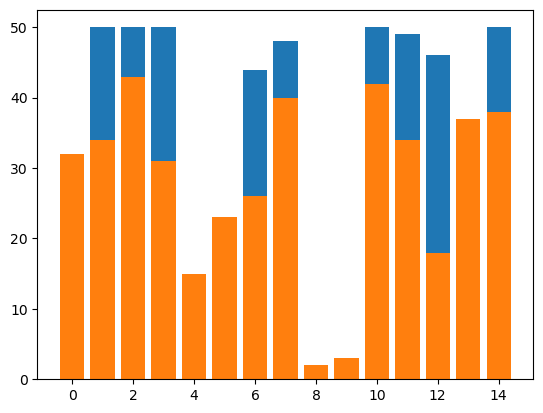

In [141]:
plt.bar(np.arange(eventsSize.shape[0]),eventsBlocks[:,0])
plt.bar(np.arange(eventsSize.shape[0]),ls[:,0])


In [15]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float32) 
v = np.zeros(L,dtype=np.float32)
t = 0

In [16]:
x,v,t,eventsSize,eventsBlock = run(x,v,t,1_000_000)

/tmp/ipykernel_6185/3979528276.py:4: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  l1 = acc(x,v,t)


In [24]:
tenstion(x,v,t)

array([ 0.92941733,  0.39425291,  0.4371245 ,  0.71820021,  0.70737958,
        0.60290386,  0.62557907,  0.61770189,  0.61775298,  0.67026785,
        0.64546022,  0.6365137 ,  0.62800613,  0.62532608,  0.6189285 ,
        0.62843162,  0.64384358,  0.59178559,  0.7004657 ,  0.59966988,
        0.60100563,  0.58277573,  0.56930126,  0.57896695,  0.59328478,
        0.66335909,  0.62447646,  0.54804957,  0.59503295,  0.56122593,
        0.57973318,  0.60369594,  0.6053518 ,  0.55898939,  0.53016622,
        0.52690777,  0.58243967,  0.58768241,  0.58523719,  0.5481633 ,
        0.43488768,  0.33948725,  0.40667135,  0.29418131,  0.22082487,
        0.59470805,  0.46832282,  0.39387153,  0.29062339, -0.11250414])

In [13]:
parts = 2000
steps = 1_000_000
eventsSizes = np.array([]).reshape((0,1))
eventsBlocks = np.array([]).reshape((0,1))
for p in range(parts):
    x,v,t,eventsSize,eventsBlock = run(x,v,t,steps)
    eventsSizes = np.concatenate((eventsSizes,eventsSize))
    eventsBlocks = np.concatenate((eventsBlocks,eventsBlock))
    print(p)

np.save("eventsSizes",eventsSizes)
np.save("eventsBlocks",eventsBlocks)

    

0
1


In [ ]:
dists = []
for i in range(L):
    dists.append(eventsSizes[eventsBlocks==i])

In [ ]:
plt.hist(eventsSizes[eventsBlocks==1],bins=300)

In [ ]:
plt.hist(eventsSizes)

In [ ]:
freq,size = np.histogram(eventsSizes)

In [ ]:
#slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[:-1]),np.log(freq))

plt.title("frequency vs size")
plt.xlabel("event size")
plt.ylabel("event frequency")
plt.scatter(np.log(size[:-1]),np.log(freq))
#plt.plot([np.log(size[0]),np.log(size[-2])],[intercept + slope.astype(np.float32)*np.log(size[0]), intercept + slope.astype(np.float32)*np.log(size[-2])])
#plt.text(-1,10,s = f"slope = {np.round(slope,3)}, intercept = {np.round(intercept,3)}, rval = {np.round(rvalue,3)}")
plt.savefig("plot.png")

In [ ]:
x = 0
v = 0
t = 0
steps = 100_000
xData = np.zeros(steps)
vData = np.zeros(steps)

In [ ]:
for i in range(steps):
    xData[i] = x
    vData[i] = v
    x,v,t = step2(x,v,t)


In [ ]:
plt.plot(np.arange(steps),xData)

In [ ]:
plt.plot(np.arange(steps),vData)

In [ ]:
tensionData= np.zeros(steps)
for i in range(steps):
    tensionData[i] = tenstion(xData[i],vData[i],i*h)

In [ ]:
fData= np.zeros(steps)
for i in range(steps):
    fData[i] = f2(xData[i],vData[i],i*h)

In [ ]:
plt.plot(np.arange(9900,10100),xData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),vData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),fData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),tensionData[9900:10100])

In [ ]:
plt.plot(np.arange(steps),tensionData)